## PV Lib Transposition Analysis

Using PV Lib from Sandia to calculate Plane of Array Irradiance for fixed tilt and tracking projects via the Perez Transposition Algorithm

https://renewable-analytics.netlify.com/1/01/01/

In [ ]:
#libraries and constants
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize": (12, 6)})
import numpy as np
import pandas as pd
import pvlib
import warnings
warnings.filterwarnings('ignore')
#nrel nsrdb API key
api_key='LhVBL5knO2kvXXwbrbgAtYUL5aGbwqLfuegppGzJ'

# User entered constants
location = pvlib.location.Location(32.2,-111, 'US/Arizona', 700, 'Tucson')
year = 2010
interval='60'

# atmospheric constants
albedo=.2

# fixed tilt inputs
surface_tilt=22.5
surface_azimuth=180

# tracking inputs
axis_tilt=0
axis_azimuth=180
max_angle=52,
backtrack=True
gcr=.5

# date to plot
plotDate='2010-03-11'

# NSRDB Query

In [84]:
# nsrdb query

utc='false'
# attributes = 'ghi,dhi,dni,wind_speed_10m_nwp,surface_air_temperature_nwp,solar_zenith_angle'
attributes = 'ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle'

leap_year = 'false'
name  = 'Stephen+Lightfoote'
reason_for_use = 'solar+resource'
affiliation = 'AWSTruepower'
email = 'slightfoote@awstruepower.com'
mailing_list = 'false'
url = 'http://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=location.latitude, lon=location.longitude, leap=leap_year, interval=interval, utc=utc, name=name,email=email, mailing_list=mailing_list, affiliation=affiliation, reason=reason_for_use, api=api_key, attr=attributes)

# Return just the first 2 lines to get metadata:
info = pd.read_csv(url, nrows=1)

# See metadata for specified properties, e.g., timezone and elevation
timezone, elevation = info['Local Time Zone'], info['Elevation']

# get data
df = pd.read_csv('http://developer.nrel.gov/api'
                 '/solar/nsrdb_psm3_download.csv?wkt=POINT({lon}%20{lat})&'
                 'names={year}&leap_day={leap}&interval={interval}&utc={utc}&'
                 'full_name={name}&email={email}&affiliation={affiliation}&'
                 'mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'
                 .format(year=year, lat=location.latitude, lon=location.longitude, leap=leap_year, interval=interval, utc=utc, 
                         name=name, email=email, mailing_list=mailing_list, affiliation=affiliation, 
                         reason=reason_for_use, api=api_key, attr=attributes), skiprows=2)
df = df.set_index(pd.DatetimeIndex(start='2010-01-01 00:30', end='2010-12-31 23:30', freq='1h',tz=location.tz))
df['times']= df.index

## NSRDB Data

In [60]:
print(df.head(24))

                           Year  Month  Day  Hour  Minute  GHI  DHI  DNI  \
2010-01-01 00:30:00-07:00  2010      1    1     0      30    0    0    0   
2010-01-01 01:30:00-07:00  2010      1    1     1      30    0    0    0   
2010-01-01 02:30:00-07:00  2010      1    1     2      30    0    0    0   
2010-01-01 03:30:00-07:00  2010      1    1     3      30    0    0    0   
2010-01-01 04:30:00-07:00  2010      1    1     4      30    0    0    0   
2010-01-01 05:30:00-07:00  2010      1    1     5      30    0    0    0   
2010-01-01 06:30:00-07:00  2010      1    1     6      30    0    0    0   
2010-01-01 07:30:00-07:00  2010      1    1     7      30    0    0    0   
2010-01-01 08:30:00-07:00  2010      1    1     8      30  170   40  688   
2010-01-01 09:30:00-07:00  2010      1    1     9      30  354   56  857   
2010-01-01 10:30:00-07:00  2010      1    1    10      30  502   64  930   
2010-01-01 11:30:00-07:00  2010      1    1    11      30  595   71  959   
2010-01-01 1

In [71]:
#df.plot()

## Solar Position

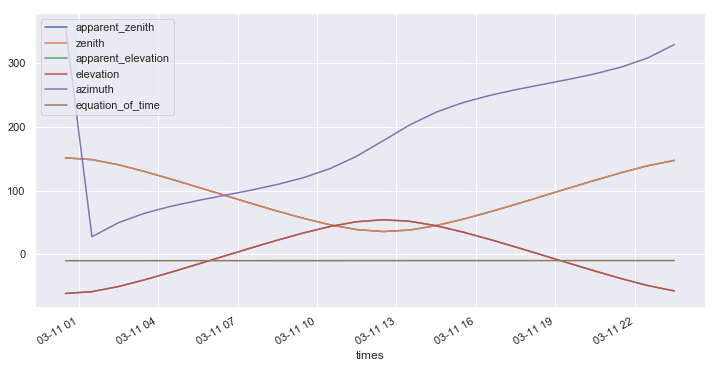

In [72]:
solpos = location.get_solarposition(df.times)
solpos[plotDate:plotDate].plot()

## Extraterrestrial Radiation

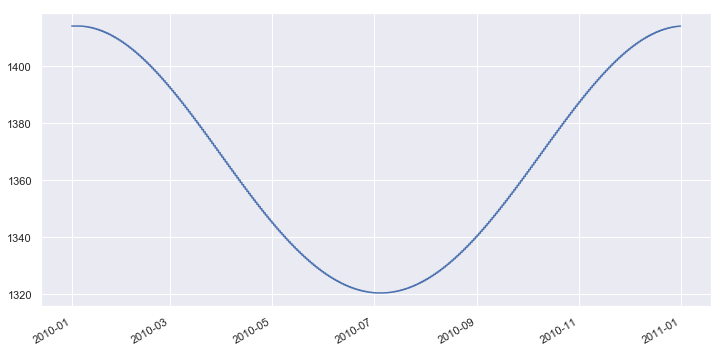

In [73]:
dni_extra = pvlib.irradiance.extraradiation(df.index)
dni_extra = pd.Series(dni_extra, index=df.index)
dni_extra.plot()

## Air Mass

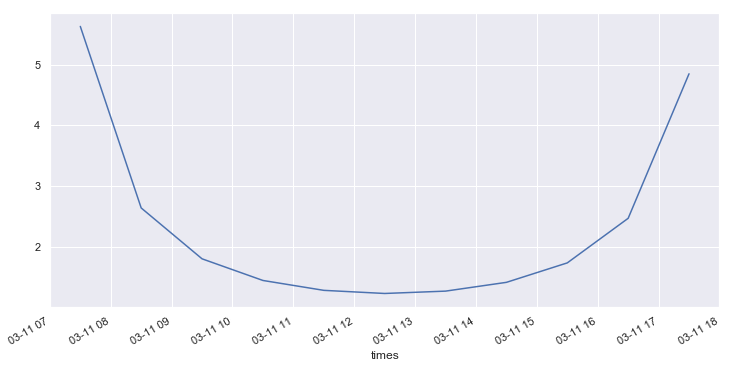

In [74]:
airmass = pvlib.atmosphere.relativeairmass(solpos['apparent_zenith'])
airmass[plotDate:plotDate].plot()

## Angle of Indicence

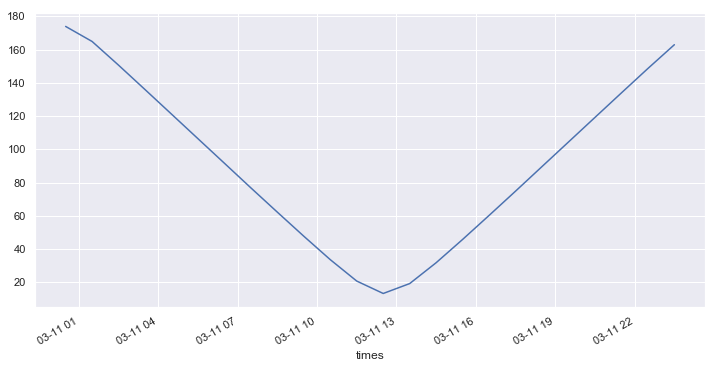

In [75]:
# angle of indicence
aoi = pvlib.irradiance.aoi(surface_tilt,surface_azimuth,solpos['apparent_zenith'], solpos['azimuth'])
aoi[plotDate:plotDate].plot()

## Plane of Array
Using the Perez Transposition Model

### Fixed Tilt

In [85]:
# plane of array irradiance fixed tilt
total_irrad = pvlib.irradiance.total_irrad(surface_tilt=surface_tilt,
                                           surface_azimuth=surface_azimuth,
                                           apparent_zenith=solpos['apparent_zenith'],
                                           albedo=albedo,
                                           azimuth=solpos['azimuth'],
                                           dni=df['DNI'],
                                           ghi=df['GHI'],
                                           dhi=df['DHI'],
                                           dni_extra=dni_extra,
                                           model='perez',
                                           solar_zenith=solpos['zenith'],
                                           airmass=airmass)

TypeError: get_total_irradiance() missing 1 required positional argument: 'solar_azimuth'

In [78]:
# plot some sample data
df['poa_global_fixed']=total_irrad.poa_global
df[plotDate:plotDate][['GHI','poa_global_fixed','DNI','DHI']].plot()
df.plot(x='times',y=['poa_global_fixed','GHI','DHI'])

NameError: name 'total_irrad' is not defined

## Single Axis Tracking

In [80]:
tracker_data = pvlib.tracking.singleaxis(solpos['apparent_zenith'], solpos['azimuth'],
                                         axis_tilt=0, axis_azimuth=180, max_angle=52,
                                         backtrack=True, gcr=.5)

perez_diffuse = pvlib.irradiance.perez(tracker_data['surface_tilt'], tracker_data['surface_azimuth'], 
                                                df['DHI'], df['DNI'], dni_extra,
                                                solpos['apparent_zenith'], solpos['azimuth'],airmass=airmass)

ground_irrad = pvlib.irradiance.grounddiffuse(tracker_data['surface_tilt'], df['GHI'], albedo=albedo)
poa_global_tracking = pvlib.tools.cosd(tracker_data['aoi'])*df['DNI'] + perez_diffuse + ground_irrad
poa_global_tracking[np.isnan(poa_global_tracking)]=0

## Comparison

In [82]:
df['poa_global_tracking']=poa_global_tracking
df[plotDate:plotDate][['GHI','poa_global_fixed','poa_global_tracking','DNI','DHI']].plot()
df.plot(x='times',y=['poa_global_fixed','poa_global_tracking','GHI','DHI'])

<matplotlib.axes._subplots.AxesSubplot at 0x2aede9d72b0>

print(df[['GHI','poa_global_fixed','poa_global_tracking']].sum()*.001)

SyntaxError: invalid syntax (<ipython-input-82-9571ca734f47>, line 5)

In [83]:
print(df[['GHI','poa_global_fixed','poa_global_tracking']].sum()*.001)

KeyError: "['poa_global_fixed' 'poa_global_tracking'] not in index"